<a href="https://colab.research.google.com/github/pranshumalik14/intuitive-arm-reach/blob/main/notebooks/dmp_pdff_kinematic_sim_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

## Purpose
- first have to make arm
- with qdotdot, simulate arm (show traj/gif)
- optionally, extract qdotdot using DMPs (through MATLAB)

In [23]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg as LA
import matplotlib.animation as animation
from collections import deque
import time
from IPython import display

%matplotlib inline

# Kinematic Simulation for N-Link Planar Arm Reach Task Using PDFF and DMPs
We can take input of $\ddot{q}$ or also DMP class object with basis centers and $\Theta$ param matrix
Some simple maths show and do in code.

In [2]:
class RobotArm2D:
    def __init__(self, n_dims = 2, arm_length = 0.8, rel_link_lengths = np.array([2, 0.6, 0.4, 0.15, 0.15, 0.1])):
        self.n_dims = n_dims
        self.arm_length = arm_length
        self.link_lengths = arm_length/sum(rel_link_lengths) * rel_link_lengths[0:n_dims+1]
        # np.array([1.5, 1.25, 0.4, 0.15, 0.15, 0.1])

    def get_arm_params(self):
        return self.n_dims, self.arm_length, self.link_lengths

In [3]:
def numpy_linspace(start, stop, step):
    return np.linspace(start, stop, int( (stop-start)/step ) + 1)

class TaskInfo2D:
    def __init__(self, robotarm, lambda_min, lambda_max, B, K, N, T, h, target_xy, dt):
        self.robotarm = robotarm
        self.lambda_min = lambda_min
        self.lambda_max = lambda_max
        self.B = B
        self.K = K
        self.N = N
        self.T = T
        self.h = h #eliteness param
        self.dt = dt
        self.target_xy = target_xy
        
        
        self.w = T / (2 * B)
        
        def gen_cs(w, T):
            return w + numpy_linspace(0, T, 2*w) # step is 2*w
        self.cs = gen_cs(self.w, T)
    
    def get_robot_arm_2D(self):
        return self.robotarm
    
    def get_lambda_min(self):
        return self.lambda_min
    
    def get_lambda_max(self):
        return self.lambda_max
    
    def get_target_xy(self):
        return self.target_xy
    
    def get_B(self):
        return self.B
    
    def get_K(self):
        return self.K
    
    def get_N(self):
        return self.N
    
    def get_T(self):
        return self.T
    
    def get_h(self):
        return self.h
    
    def get_dt(self):
        return self.dt
    
    def get_w(self):
        return self.w
    
    def get_cs(self):
        return self.cs   

In [4]:
def get_traj(qdotdot, robot_arm, dt, init_condit = [None, None]):
    """
    Takes in a joint accelerations qdotdot, and return 
    
    Keyword arguments:
    argument -- qdotdot: an t x n_dim matrix (t timesteps, n_dim dimensions) (numpy array)
    Return: return_description
    """
    
    n_time_steps = qdotdot.shape[0]
    n_dims_qdotdot = qdotdot.shape[1] if qdotdot.ndim > 1 else 1

    n_dims, arm_length, link_lengths = robot_arm.get_arm_params()
    assert(n_dims == n_dims_qdotdot)

    time_steps = dt * np.arange(n_time_steps)
    
    # initialize q, qdot to 0
    q = np.zeros((n_time_steps, n_dims))
    qdot = np.zeros((n_time_steps, n_dims))
    
    if init_condit is not None:
        q0, qdot0 = init_condit[0], init_condit[1]
        assert(qdot.shape[1] == len(qdot0))
        qdot[0, :] = qdot0
        q[0, :] = q0
    else:
        # if None, then assume 0 init conditions
        pass
    
    if qdotdot.ndim > 1:
        for i in range(1, n_time_steps):
            qdot[i, :] = qdot[i-1, :] + dt*qdotdot[i, :]
            q[i, :] = q[i-1, :] + dt*qdot[i, :]
    else:
        for i in range(1, n_time_steps):
            qdot[i] = qdot[i-1] + dt*qdotdot[i]
            q[i] = q[i-1] + dt*qdot[i]
        
    # Could use np.trapez but it gave me some weird error
    # qdot[:,0] = np.trapez(qdotdot, x = time_steps)     
    # https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html

    return time_steps, q, qdot, qdotdot



## Creating test data

2 joints; each with a sinusoidal movement

In [ ]:
# Each joint has sinusoidal movement
# base frequency
omega = 1
multi_factor = 1 # second joint rotates 5 times faster
slowness_factor = 0.1

n_time_steps = 1001
dt = 0.005
time_steps = dt * np.arange(n_time_steps)

n_dims = 2
qdotdot = np.zeros((n_time_steps, n_dims))


# This is the first joint (base joint)
freq_0 = 2*np.pi*omega*slowness_factor
qdotdot[:,0] = (2*np.pi)*(freq_0**2)*np.sin(freq_0*time_steps) 

# This is the second joint
freq_1 = 2*np.pi*multi_factor*omega
# qdotdot[:,1] = (2*np.pi)*(freq_1**2)*np.sin(freq_1*time_steps)
qdotdot[:,1] = 0*time_steps

q0 = [0, 0] # starting joint configuration
# qdot0 = [-(2*np.pi)*(freq_0), -(2*np.pi)*(freq_1)]
qdot0 = [-(2*np.pi)*(freq_0), (2*np.pi)*(freq_1)]
init_condit = [q0, qdot0]


In [ ]:
robot_arm = RobotArm2D(n_dims = n_dims) # by default takes two joints

time_steps, q, qdot, qdotdot = get_traj( qdotdot, robot_arm, init_condit = [ q0, qdot0 ], dt = dt)
pts_to_trace = 1001
%matplotlib inline
# plt.figure()
plt.title('$\ddot{q}$ over time')
plt.plot(time_steps[:pts_to_trace], qdotdot[:pts_to_trace, 0])
# plt.plot(time_steps[:pts_to_trace], qdotdot[:pts_to_trace, 1])

plt.figure()
plt.title('$\dot{q}$ over time')
plt.plot(time_steps[:pts_to_trace], qdot[:pts_to_trace, 0])
# plt.plot(time_steps[:pts_to_trace], qdot[:pts_to_trace, 1])

plt.figure()
plt.title('$q$ over time')
plt.plot(time_steps[:pts_to_trace], q[:pts_to_trace, 0])
# plt.plot(time_steps[:pts_to_trace], q[:pts_to_trace, 1])


In [5]:
def angles_to_link_positions_2D(q, robot_arm):
    # Forward kinematics
    n_time_steps = q.shape[0]
    n_dims = q.shape[1]
    
    n_dims_robot, arm_length, link_lengths = robot_arm.get_arm_params()
    assert(n_dims == n_dims_robot)
    
    links_x = np.zeros((n_time_steps, n_dims+1))
    links_y = np.zeros((n_time_steps, n_dims+1))
    
    for t in range(n_time_steps):
        sum_angles = 0
        
        for i_dim in range(n_dims):
            sum_angles += q[t, i_dim]
            links_x[t, i_dim + 1] = links_x[t, i_dim] + np.cos(sum_angles) * link_lengths[i_dim]
            links_y[t, i_dim + 1] = links_y[t, i_dim] + np.sin(sum_angles) * link_lengths[i_dim]
            
    link_positions = np.zeros((n_time_steps, 2*(n_dims+1)))
    # desired structure of link positions is x y x y x y 
    # (first x y are for the base joint)
    for n in range(n_dims + 1):
        link_positions[:, 2*n] = links_x[:,n]
        link_positions[:, 2*n+1] = links_y[:,n]
    
    return link_positions

In [ ]:
# forward kinematics
link_positions = angles_to_link_positions_2D(q, robot_arm)

In [ ]:
plt.figure()

plt.plot(link_positions[:,2], link_positions[:,3])
plt.plot(link_positions[:,4], link_positions[:,5])

In [53]:
%matplotlib notebook
%matplotlib notebook

def get_traj_and_simulate(qdotdot, robot_arm, x_goal, init_condit, dt):
    """
    
    """
    # initial checks
    assert(len(x_goal) == 2)
    
    # Get q and qdot
    time_steps, q, qdot, qdotdot = get_traj( qdotdot, robot_arm, init_condit = init_condit, dt = dt)
    n_time_steps = len(time_steps)
    
    # Forward kinematics
    link_positions = angles_to_link_positions_2D(q, robot_arm)
    
    # Robot params
    n_dims, arm_length, link_lengths = robot_arm.get_arm_params()
    
    # Figure set up
    fig = plt.figure()
    padding_factor = 1.5
    axes_lim = arm_length*padding_factor
    
    ax = fig.add_subplot(autoscale_on=False, xlim=(-axes_lim, axes_lim), ylim=(-axes_lim, axes_lim))
    ax.set_aspect('equal')
    ax.grid()
    
    # tracking the history of movements
    tracking_history_points = 1000
    history_x, history_y = deque(maxlen=tracking_history_points), deque(maxlen=tracking_history_points)

    # Adding the base of the robot arm
    points = [[0, 0], [-0.05, -0.1], [0.05, -0.1]]
    line = plt.Polygon(points, closed = True, fill = True, color = 'red')
    plt.gca().add_patch(line)

    # Dynamic lines (theese are the lines/vals that will update during the simulation)     
    line, = ax.plot([], [], 'o-', lw=2)
    trace, = ax.plot([], [], '.-', lw=1, ms=2)
    time_template = 'time = %.1fs'
    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
    
    # Annotations for each link/end effector
    annotate_links = []
    for n in range(n_dims):
        link_to_annotate = "q{}".format(str(1+n))
        annotate_links.append(ax.annotate(link_to_annotate, xy = (link_lengths[n], 0)))
    
    annotate_end_effector = ax.annotate('E', xy = (link_lengths[-1] , 0))

    # animation for each frame
    def animate(i):
        # all x axis values are in the even-numbered columns
        thisx = [link_positions[i, j] for j in range(0, len(link_positions[0,:]), 2)]
        
        # all y axis value are in the odd-numbered columns
        thisy = [link_positions[i, j] for j in range(1, len(link_positions[0,:]), 2)]

        if i == 0:
            history_x.clear()
            history_y.clear()

        # History only tracks the end effector        
        history_x.appendleft(thisx[-1])
        history_y.appendleft(thisy[-1])
        
        # Set current state of (x,y) for each joint
        line.set_data(thisx, thisy)
        trace.set_data(history_x, history_y)
        time_text.set_text(time_template % (i*dt))

        offset_factor = 0.3
        for n in range(n_dims):
            annotate_links[n].set_position(
                (
                link_positions[i, 2*n] + offset_factor*link_lengths[n]*np.cos(q[i,n]),
                link_positions[i, 2*n+1] + offset_factor*link_lengths[n]*np.sin(q[i,n])
                )
            )

        annotate_end_effector.set_position((
            link_positions[i, len(link_positions[0,:])-2],
            link_positions[i, -1]
        ))

        return line, trace, time_text

    ani = animation.FuncAnimation(
        fig, animate, n_time_steps, interval = dt* n_time_steps, blit= True
    )
    
    # Goal position
    plt.plot(x_goal[0], x_goal[1], '-o') # Goal position
    ax.annotate('x_g',xy = (x_goal[0], x_goal[1]))

    fig.suptitle('Kinematic Simulation', fontsize=14)
    
    return time_steps, q, qdot, qdotdot, ani
    

In [ ]:
from IPython import display

x_target = np.array([0, -0.5])
time_steps, q, qdot, qdotdot, ani = get_traj_and_simulate(qdotdot, robot_arm, x_target, init_condit = init_condit)

video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()
# path = r"~/demo.gif"
# ani.save(path, fps=60)

# Task Specification

In [7]:
def acceleration_cost(qdotdot, t):
  N = qdotdot.shape[1]
  numerator = 0
  for n in range(qdotdot.shape[1]):
    numerator += (N+1-n) * qdotdot[t, n]**2
  return numerator

In [8]:
def cost_function(x_target, q, qdotdot, robot_arm, kt = 1e-5, kT = 1e2):
  fk = angles_to_link_positions_2D(q, robot_arm)
  fk_dim = fk.shape[1] # x y for each dim 
  x_TN = np.array([fk[-1, fk_dim-2], fk[-1, fk_dim-1]])
  # take the last row and last column/second last column

  # reach cost
  norm_reach_cost = np.linalg.norm(x_TN - x_target)**2 # The squared-distance between the end-effector and the goal positions at the end of the movement
  comfort_cost = np.max(q[-1, :]) #: A cost that corresponds to the largest angle over all the joints at the end of the movement
  C_T = kT*(norm_reach_cost) + comfort_cost

  # acce cost
  N = qdotdot.shape[1]
  denom = 0
  for n in range(qdotdot.shape[1]):
    denom += (N+1 - n)

  acce_cost = 0
  for t in range(qdotdot.shape[0]):
    acce_cost += acceleration_cost(qdotdot, t)
  acce_cost = (kt*acce_cost)/denom

  # objective function
  J_Qdd = C_T + acce_cost
  return J_Qdd

In [ ]:
# code for 2D animation or plot display of the reach task
#   1. should be able to take a goal point and display it (as star/dot)
#   2. work/plot for N-DOF planar
#   3. show radius for reach task completion tolerance
#   4. animate movement for the range of angles (show similar to gifs/anims here: https://github.com/pranshumalik14/analog-ctrl/blob/master/analog_ik/2dof_idea_overview.gif)

# PIBB: Blackbox Stochastic Optimization

## Helper functions

In [9]:
def psi(c, t, w):
    return np.exp(-((t-c)/w)**2)

def psi_cumulative(t, cs, w, B):
    return [psi(cs[b], t, w) for b in range(B)]

def g(b, t, task_info):
    cs = task_info.get_cs()
    B = task_info.get_B()
    w = task_info.get_w()
    return psi(cs[b], t, w)/sum(psi_cumulative(t, cs, w, B))

def g_over_b(task_info, t):
    B = task_info.get_B()
    return np.array([g(b, t, task_info) for b in range(B)])

def qdotdot_gen(task_info, Theta, t):
    return np.matmul(Theta.transpose(), g_over_b(task_info, t))

In [10]:
def eval_rollout(task_info, Theta_matrix, init_condit):   
    T = task_info.get_T()     
    dt = task_info.get_dt()  
    robot_arm = task_info.get_robot_arm_2D()
    target_xy = task_info.get_target_xy()
    
    # J(Θ) = hcat([q̈(Θ, t) for t ∈ 0:Δt:T]...) |> J̃; # J = J(q̈(Θ), 0:Δt:T)
    gen_qdotdot = np.array(
        [qdotdot_gen(task_info, Theta_matrix, t) for t in numpy_linspace(0, T, dt)]
    )
    
    _, gen_q, _, _ = get_traj(gen_qdotdot, robot_arm, dt, init_condit)
    return cost_function(target_xy, gen_q, gen_qdotdot, robot_arm)

In [41]:
def boundcovar(Sigma, lambda_min, lambda_max):
    eigvals, eigvecs = LA.eig(Sigma)   
    eigvals = np.clip(np.abs(eigvals), lambda_min, lambda_max) * np.sign(eigvals)
    Sigma = eigvecs * eigvals*np.eye(len(eigvals)) * LA.inv(eigvecs)
    
    return Sigma + 1e-6*np.eye(len(eigvals))
# https://stackoverflow.com/questions/41515522/numpy-positive-semi-definite-warning

In [45]:
def PIBB(task_info, Theta, Sigma, init_condit, tol = 1e-3, max_iter = 1000):
    print("######################### PIBB Algorithm Started #########################")
    start_time = time.time()
    
    robot_arm_2D = task_info.get_robot_arm_2D() 
    lambda_min = task_info.get_lambda_min()
    lambda_max = task_info.get_lambda_max()
    
    B = task_info.get_B()
    K = task_info.get_K()    
    N = task_info.get_N()    
    T = task_info.get_T()    
    h = task_info.get_h()    
    dt = task_info.get_dt()    
    w = task_info.get_w()    
    cs = task_info.get_cs()
    
    iter_count = 0
    delta_J = eval_rollout(task_info, Theta, init_condit)
    J_hist = [delta_J]

    Thetas = np.zeros(B * K * N).reshape((B, K, N))
    Ps = Js = np.zeros(K)
    
    while (iter_count < max_iter) and (abs(delta_J) > tol):
        iter_count += 1
        
#         print("######################### ITER COUNT: {} #########################".format(iter_count))
        
        # Sigma shape is N, B, B
        # Theta shape is B, N
        
        for k in range(K):
            
            Thetas[: , k, : ] = np.array(
                [np.random.multivariate_normal(Theta[: , n], Sigma[n, : , :]) for n in range(N)]
            ).transpose()

            Js[k] = eval_rollout(task_info, Thetas[: , k, : ], init_condit)
            
        J_min = np.min(Js)
        J_max = np.max(Js)

        den = sum([np.exp(-h * (Js[l] - J_min) / (J_max - J_min)) for l in range(K)])
        for k in range(K):
            Ps[k] = np.exp(-h * (Js[k] - J_min) / (J_max - J_min)) / den
        
        Sigma = np.zeros(B * B * N).reshape((N, B, B))

        for n in range(N):
            for k in range(K):        
                
                x = Ps[k] * \
                    np.matmul(
                        np.array([ (Thetas[:, k, n] - Theta[:, n]) ]).transpose(),
                        np.array([ (Thetas[:, k, n] - Theta[:, n]) ])
                    )
                Sigma[n, : , :] += x
                
            Sigma[n, : , :] = boundcovar(Sigma[n, : , :], lambda_min, lambda_max)

        Theta = np.zeros(B * N).reshape((B, N))

        for k in range(K):
            Theta += (Ps[k] * Thetas[: , k, : ])

        J_hist.append(eval_rollout(task_info, Theta, init_condit))

        last_5_J = J_hist[-5: ]# is safe
        # function(works even when no of elements is less than 5)
        delta_J = np.mean(np.diff(last_5_J))
    
    print("######################### PIBB Algorithm Finished. Time Elapsed : {} #########################".format(time.time() - start_time))
    return Theta, iter_count, J_hist

In [13]:
# returns xy xy xy (six columns) base, joint 1, end effector (in a 2-links case)
# need to take the last two columns
# T = 1

x_target = np.array([-0.3, 0.3])
init_condit = [np.array([np.pi/8, np.pi/4, np.pi/5]), np.array([0, 0, 0])]
robot_arm = RobotArm2D(
    n_dims = 3,
    arm_length = 1.0, 
    rel_link_lengths = np.array([0.6, 0.3, 0.1])
)

In [14]:
lambda_init = lambda_min = 0.05; lambda_max = 5; # exploration levels; TODO: set λₘₐₓ acc. to need
# Σ = cat([Diagonal(λᵢₙᵢₜ*I, B) for i in range(N)]); dims=3); # covar matrix with 3d dimensions
# Sample data
B = 10
K = 20
N = 3
Sigma_matrix = np.array( [lambda_init*np.eye(B) for i in range(N)] )

# Shape should be B * B * N but we have N * B * B -> indexing has to change accordingly
Theta_matrix = np.zeros(B*N).reshape((B,N));               # no default action to start with

task_info = TaskInfo2D(
    robotarm = robot_arm,
    lambda_min = lambda_min,
    lambda_max = lambda_max,
    B = B,
    K = K,
    N = N,
    T = 1,
    h = 10,
    target_xy = x_target,
    dt = 1e-2
)

In [46]:
Theta, iter_count, J_hist = PIBB(task_info, Theta_matrix, Sigma_matrix, init_condit)

######################### PIBB Algorithm Started #########################
######################### PIBB Algorithm Finished. Time Elapsed : 51.55639982223511 #########################


In [16]:
Theta

array([[11.09666156,  0.16648253,  0.08931105],
       [ 0.20854375, 10.5372442 , -0.16793301],
       [ 1.68362092,  2.23920363,  0.73716013],
       [ 1.18399668,  0.9669295 ,  1.11540189],
       [ 0.59440785,  1.78906757,  1.12773761],
       [ 0.11149673,  0.96403069,  1.09642432],
       [ 0.18387818,  0.45666405, -0.22260743],
       [ 0.66225672,  0.26329997,  0.22142042],
       [-0.28149073,  0.52730555, -0.12832178],
       [ 0.71782639, -0.88740074, -0.31471189]])

<IPython.core.display.Javascript object>


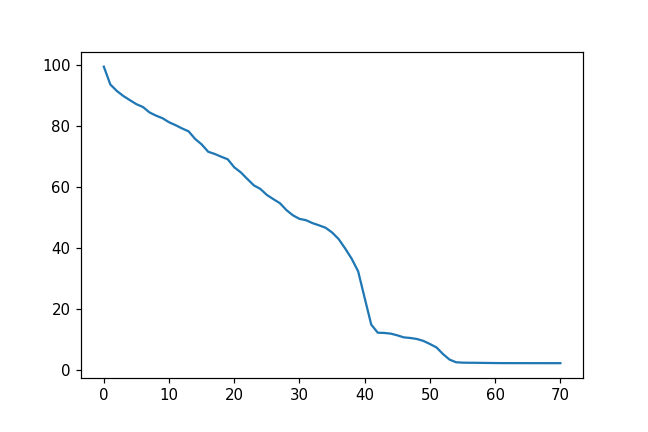

In [17]:
plt.plot(range(iter_count+1), J_hist)

<IPython.core.display.Javascript object>


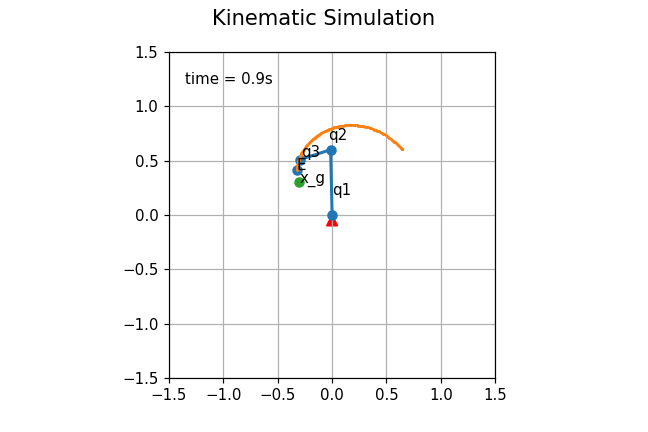

In [56]:
gen_qdotdot = np.array(
    [qdotdot_gen(task_info, Theta, t) for t in numpy_linspace(0, 1, 1e-2)]
)

time_steps, q, qdot, gen_qdotdot, ani = get_traj_and_simulate(gen_qdotdot, robot_arm, x_target, init_condit = init_condit, dt = 0.01)
# conda install -c conda-forge ffmpeg
video = ani.to_jshtml(fps = 60)
# video = ani.to_html5_video() # to save as mp4, use this
html = display.HTML(video)
display.display(html)

In [ ]:
#  Clean up & Comments
#  Port code to Python file

# Dynamic Simulation of 3D Robotic Arm Reach Tasks

In [ ]:
# optional: show a sample full dynamic simulation can be done for arms implemented in RTB 
# (Robotics Toolbox for Python, Peter Corke et al.),
# or we can implement our model of arm in RTB and simulate joint trajectories.

# in case of PDFF training, we can include that in our 
# so the PDFF rollout has to be generic enough to allow different simulators (kin/dyn) and arms (2D/3D -- which would need DH stuff)

# but for now, since the primary focus of the project is on planar arms, we can do that
# almost exclusively until the whole framework/process-flow is ready enough to proceed to 
# full 3D

# note that this work (2D generalization and 3D sim bootstrap for PDFF) will be the unique
# contributions of this work. 